<a href="https://colab.research.google.com/github/woranov/amlta-project/blob/main/notebooks/tapas_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
try:
    import amlta  # noqa: F401
except ImportError:
    %pip install -q --no-dependencies -U git+https://github.com/woranov/amlta-project.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
from pathlib import Path

try:
    from google.colab import drive  # pyright: ignore[reportMissingImports]

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from amlta.config import config

In [4]:
if IN_COLAB:
    mount_point = Path("/content/drive")
    drive_path = mount_point / "MyDrive"

    # edit
    data_dir = drive_path / "uni" / "ws2425" / "amlta" / "project" / "data"

    config.update(data_dir=data_dir)

    if not mount_point.exists():
        drive.mount(str(mount_point))

Mounted at /content/drive


In [77]:
import json

import numpy as np
import pandas as pd
import torch
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    average_precision_score,
    classification_report,
    confusion_matrix,
    fbeta_score,
    jaccard_score,
)
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import thread_map

from amlta.probas.flows import extract_process_flows
from amlta.probas.processes import ProcessData
from amlta.question_generation.process import (
    QuestionData,
    load_batches,
)
from amlta.question_generation.query_params import get_flows_for_query
from amlta.tapas.model import load_tapas_model, load_tapas_tokenizer, TapasForQuestionAnswering
from amlta.tapas.retrieve import retrieve_rows

In [8]:
training_df = pd.read_parquet(
    config.data_dir / "tapas-ft" / "data" / "tapas_train_batched_dfs_shuffled.parquet"
)

In [9]:
not_trained_on_data = training_df.iloc[int(len(training_df) * 0.8) :]
start_batch = not_trained_on_data["batch"].values[0]
start_question_id = int(not_trained_on_data["question_id"].values[0])
start_process_uuid = not_trained_on_data["process_uuid"].values[0]

In [7]:
tokenizer = load_tapas_tokenizer()
model = load_tapas_model()

tokenizer_config.json:   0%|          | 0.00/490 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/262k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/154 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'TapasTokenizer'. 
The class this function is called from is 'CustomTapasTokenizer'.


config.json:   0%|          | 0.00/1.69k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [ ]:
model = load_tapas_model()

In [10]:
question_data = load_batches()
print(question_data[-1])

len(question_data)

{'batch': 'batch_gpt-4o-mini_800_1000', 'process_uuid': 'ecf185cb-c44b-4450-abc4-a92c4bf0b9b9', 'question_id': 2, 'basic_query': 'metal production', 'general_query': 'non-ferrous metal production', 'specific_query': 'aluminum production in Germany 2015', 'flow_query_params': {'query_type': 'names', 'direction': 'output', 'aggregation': 'count', 'flow_names': ['HFC-245ca', 'perfluoropropane', 'CFC-11', 'nickel']}, 'question': 'What are the output amounts of HFC-245ca, perfluoropropane, CFC-11, and nickel from <the process>?', 'question_replaced_basic': 'What are the output amounts of HFC-245ca, perfluoropropane, CFC-11, and nickel from metal production?', 'question_replaced_general': 'What are the output amounts of HFC-245ca, perfluoropropane, CFC-11, and nickel from non-ferrous metal production?', 'question_replaced_specific': 'What are the output amounts of HFC-245ca, perfluoropropane, CFC-11, and nickel from aluminum production in Germany 2015?'}


3000

In [11]:
# find the last question that was part of the training data
end_tain_idx = next(
    i
    for i, q in enumerate(question_data)
    if q["batch"] == start_batch
    and q["question_id"] == start_question_id
    and q["process_uuid"] == start_process_uuid
)
valid_data = question_data[end_tain_idx + 1:]
len(valid_data)

721

In [12]:
threshold = 0.5

In [13]:
import functools


@functools.lru_cache(maxsize=512)
def get_process(uuid):
    return ProcessData.from_uuid(uuid)


@functools.lru_cache(maxsize=512)
def get_flows(uuid):
    return extract_process_flows(get_process(uuid))

In [14]:
def get_true_labels(question: QuestionData):
    df = get_flows(question["process_uuid"])

    filtered = get_flows_for_query(df, question["flow_query_params"])

    labels = df.index.isin(filtered.index).astype(bool).tolist()
    aggregation = question["flow_query_params"]["aggregation"]

    aggregation = aggregation.replace("list", "NONE").upper()

    return labels, aggregation

In [85]:
def get_tapas_labels(question: QuestionData, model=model, threshold=threshold):
    df = get_flows(question["process_uuid"])

    query = question["question"]
    query = query.replace("<", "").replace(">", "")

    rows, aggregation, probs = retrieve_rows(
        df,
        query=query,
        model=model,
        tokenizer=tokenizer,
        threshold=0,
        return_probabilities=True,
    )
    rows_sorted = []
    probs_sorted = []

    for row, prob in sorted(zip(rows, probs), key=lambda x: x[0]):
        rows_sorted.append(row)
        probs_sorted.append(prob)

    labels = [bool(prob >= threshold) for prob in probs_sorted]

    return labels, aggregation, probs_sorted

In [16]:
def average_precision_score_at_k(y_true, y_pred_probs, k):
    y_pred_idx_sorted = np.argsort(y_pred_probs)[::-1]
    top_k_idx = y_pred_idx_sorted[:k]

    y_true_sorted = np.array(y_true)[top_k_idx]
    y_pred_sorted = np.array(y_pred_probs)[top_k_idx]

    if not np.any(y_true_sorted) and np.any(y_true):
        return 0

    return average_precision_score(y_true_sorted, y_pred_sorted)


def mean_average_precision_at_k(y_trues, y_preds_probs, k):
    results = []

    for y_true, y_pred_probs in zip(y_trues, y_preds_probs):
        results.append(average_precision_score_at_k(y_true, y_pred_probs, k))

    return np.mean(results)

## Metrics on Held-out Data

In [70]:
y_preds_labels = []
y_preds_probs = []
y_preds_aggregation = []

for res in thread_map(get_tapas_labels, valid_data):
    labels, aggregation, probs = res
    y_preds_labels.append(labels)
    y_preds_probs.append(probs)
    y_preds_aggregation.append(aggregation)

  0%|          | 0/721 [00:00<?, ?it/s]

In [71]:
y_trues_labels = []
y_trues_aggregation = []

for res in thread_map(get_true_labels, valid_data):
    labels, aggregation = res
    y_trues_labels.append(labels)
    y_trues_aggregation.append(aggregation)

  0%|          | 0/721 [00:00<?, ?it/s]

In [72]:
print(
    classification_report(
        [label for labels in y_trues_labels for label in labels],
        [label for labels in y_preds_labels for label in labels],
    )
)

              precision    recall  f1-score   support

       False       0.99      0.99      0.99     48536
        True       0.92      0.94      0.93      7634

    accuracy                           0.98     56170
   macro avg       0.95      0.96      0.96     56170
weighted avg       0.98      0.98      0.98     56170



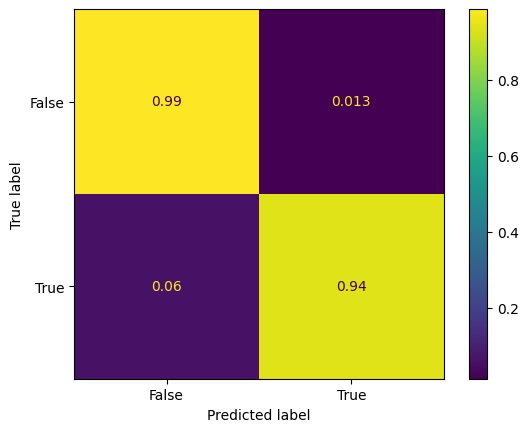

In [73]:
ConfusionMatrixDisplay.from_predictions(
    [label for labels in y_trues_labels for label in labels],
    [label for labels in y_preds_labels for label in labels],
    normalize="true",
)

In [18]:
print(classification_report(y_trues_aggregation, y_preds_aggregation))

              precision    recall  f1-score   support

     AVERAGE       0.99      1.00      1.00       174
       COUNT       0.76      0.79      0.77       178
        NONE       0.84      0.77      0.81       198
         SUM       0.89      0.94      0.91       171

    accuracy                           0.87       721
   macro avg       0.87      0.87      0.87       721
weighted avg       0.87      0.87      0.87       721



In [50]:
# f2-score putting extra weight on recall
fbeta_score(
    [label for labels in y_trues_labels for label in labels],
    [label for labels in y_preds_labels for label in labels],
    beta=2,
    average="binary",
)

0.9355192112058847

In [36]:
jaccard_score(
    [label for labels in y_trues_labels for label in labels],
    [label for labels in y_preds_labels for label in labels],
)

0.8681917211328976

In [98]:
mean_average_precision_at_k(y_trues_labels, y_preds_probs, k=5)

0.905653798736323

## Metrics on Rephrased Questions

"End-to-End"-questions of the held-out set that have been rewritten by gpt-4o-mini to be more natural and varied and then processed by our Qwen2.5 rewriting step.

In [50]:
realistic_eval_questions = [
    json.loads(line)
    for line in (config.data_dir / "generated" / "tapas-eval-questions.jsonl").read_text().splitlines()
]

In [52]:
real_y_trues_labels = []
real_y_trues_aggregation = []

for res in tqdm([q["question_data"] for q in realistic_eval_questions]):
    labels, aggregation = get_true_labels(res)
    real_y_trues_labels.append(labels)
    real_y_trues_aggregation.append(aggregation)

  0%|          | 0/100 [00:00<?, ?it/s]

In [53]:
real_y_preds_labels = []
real_y_preds_probs = []
real_y_preds_aggregation = []

transformed = [
    (q["question_data"] | {"question": q["rewritten_flows_query"]})
    for q in realistic_eval_questions
]

for res in thread_map(get_tapas_labels, transformed):
    labels, aggregation, probs = res
    real_y_preds_labels.append(labels)
    real_y_preds_probs.append(probs)
    real_y_preds_aggregation.append(aggregation)

  0%|          | 0/100 [00:00<?, ?it/s]

In [59]:
print(
    classification_report(
        [label for labels in real_y_trues_labels for label in labels],
        [label for labels in real_y_preds_labels for label in labels],
    )
)

              precision    recall  f1-score   support

       False       0.96      0.94      0.95      7023
        True       0.61      0.70      0.65       934

    accuracy                           0.91      7957
   macro avg       0.79      0.82      0.80      7957
weighted avg       0.92      0.91      0.92      7957



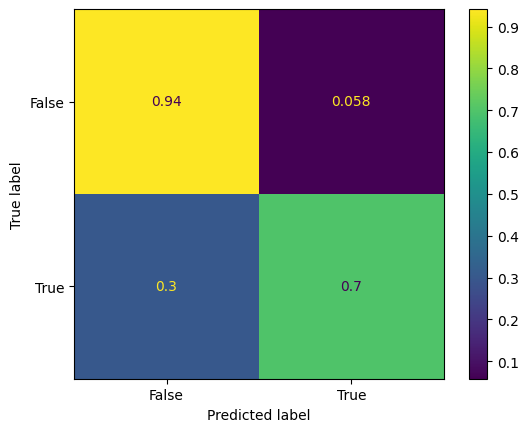

In [68]:
ConfusionMatrixDisplay.from_predictions(
    [label for labels in real_y_trues_labels for label in labels],
    [label for labels in real_y_preds_labels for label in labels],
    normalize="true",
)

In [60]:
print(classification_report(real_y_trues_aggregation, real_y_preds_aggregation))

              precision    recall  f1-score   support

     AVERAGE       1.00      0.92      0.96        24
       COUNT       0.53      0.73      0.62        22
        NONE       0.61      0.71      0.65        24
         SUM       0.90      0.60      0.72        30

    accuracy                           0.73       100
   macro avg       0.76      0.74      0.74       100
weighted avg       0.77      0.73      0.74       100



In [61]:
fbeta_score(
    [label for labels in real_y_trues_labels for label in labels],
    [label for labels in real_y_preds_labels for label in labels],
    beta=2,
    average="binary",
)

0.6795914112987284

In [62]:
jaccard_score(
    [label for labels in real_y_trues_labels for label in labels],
    [label for labels in real_y_preds_labels for label in labels],
)

0.4854802680565897

In [63]:
mean_average_precision_at_k(real_y_trues_labels, real_y_preds_probs, k=5)

0.8111527777777777